# GMM en datos de alta resolución espacial
El approach anterior separa los componentes en terminos de resolución, se observó que los componentes de baja resolución no poseen tanta variabilidad como los de alta resolución, por tanto pueden ser bien explicados por sumas de oscilaciones o modos principales con un buen porcentaje. 

Este approach espera capturar peaks importantes a partir de fits de modelos gaussianos, este notebook espera lo siguiente:
- datos en un estado pre procesado, normalizados y separados en componentes

Tiene de objetivo:
- Usar o interpretar los Kappa (y) como distribuciones, tomar o samplear puntos rapidamente y luego correr un GMM sobre esa serie de puntos.



In [52]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os

from sklearn.decomposition import IncrementalPCA # Para el PCA
from utils import CustomMinMaxScaler
from utils import filtering

from grav_lens import get_datasets


max_files = 2000
batch_size = 64
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)


with open('minmaxscaler.pkl', 'rb') as f:
    minmaxscaler = pickle.load(f)

with open('./pca_models/ipca_low.pkl', 'rb') as f:
    ipca_low = pickle.load(f)


Using data folder: ..\data\1
(64, 128, 128, 3)
(64, 128, 128, 1)


In [53]:
for X_batch, y_batch in train_dataset.take(2):
    
    y_batch = minmaxscaler.transform(y_batch) # [0, 1]
    low_freq_batch, high_freq_batch = filtering.process_batch_filters(y_batch.numpy(), cutoff=0.05)

    # ---- Low Freq ----------------
    # para poder hacer la transformación de PCA, 
    # se hace un stack de la informacion de las imagenes
    # (batch, 128*128)
    # luego el PCA entrega 64 coeficientes
    # -> (batch, 64)
    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_freq_batch])
    ipca_coef = ipca_low.transform(low_freq_stack) 
    # -----------------------------

    # ------ High Freq ------------------
    

# funciones para Gaussiana

In [62]:
# Puede mejorarse para calcular la estadistica por batch
def calculate_image_stats(image):
    """
    Calcula la media y la desviación estándar de la imagen.
    """
    mean_value = np.mean(image)
    std_value = np.std(image)
    return mean_value, std_value

def apply_threshold(image, mean_value, std_value, threshold=1.0):
    """
    Aplica un umbral a la imagen basado en la media y la desviación estándar.

    Parámetros:
        image (numpy array): Imagen en formato numpy array.
        mean_value (float): Media de los valores de la imagen.
        std_value (float): Desviación estándar de los valores de la imagen.
        threshold (float): Factor de umbral para definir el rango de valores que se mantendrán.

    Retorna:
        image_thresholded (numpy array): Imagen con valores filtrados.
    """
    lower_bound = mean_value - threshold * std_value
    upper_bound = mean_value + threshold * std_value
    
    # Filtrar la imagen utilizando el umbral
    image_thresholded_positive = np.where((image >= upper_bound), image , 0)
    image_thresholded_negative = np.where((image <= lower_bound), image, 0)
    
    return image_thresholded_positive, image_thresholded_negative

def generate_points_from_image(image, n_samples=100):
    """
    Genera una cantidad fija de puntos (x, y) a partir de una imagen, donde la cantidad de puntos es proporcional a la intensidad del pixel.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        n_samples (int): Número total de puntos a generar.
        
    Retorna:
        points (numpy array): Array de coordenadas (x, y) generadas a partir de los valores de los píxeles.
    """
    # Verificar si la imagen está vacía (todos los valores son cero)
    if np.sum(image) == 0:
        # Si está vacía, devolver una lista vacía de puntos
        return np.array([])
    
    # Aplanar la imagen para simplificar el muestreo
    flattened_image = image.flatten()
    
    # Normalizar la imagen para que sus valores sumen 1 (esto crea una distribución de probabilidad)
    probabilities = flattened_image / np.sum(flattened_image)
    
    # Generar los índices de los píxeles con muestreo ponderado según las intensidades
    chosen_indices = np.random.choice(len(flattened_image), size=n_samples, p=probabilities)
    
    # Convertir los índices planos en coordenadas (x, y)
    x_coords, y_coords = np.unravel_index(chosen_indices, image.shape)
    
    # Combinar las coordenadas en una lista de puntos (x, y)
    points = np.vstack((x_coords, y_coords)).T
    
    return points

def gaussian_2d(x, y, mux, muy, sigma_x, sigma_y, weight):
    """
    Genera una Gaussiana bidimensional.

    Parámetros:
        x, y (numpy array): Coordenadas de la cuadrícula.
        mux, muy (float): Medias en x e y.
        sigma_x, sigma_y (float): Desviaciones estándar en x e y.
        weight (float): Peso de la gaussiana.

    Retorna:
        (numpy array): Imagen generada de la gaussiana.
    """
    return weight * np.exp(-((x - mux) ** 2 / (2 * sigma_x ** 2) + (y - muy) ** 2 / (2 * sigma_y ** 2)))


def reconstruct_image_from_gmm(image_shape, means, covariances, weights):
    """
    Reconstruye la imagen a partir de los parámetros del GMM.
    
    Parámetros:
        image_shape (tuple): La forma de la imagen (ancho, alto).
        means (numpy array): Medias de las gaussianas.
        covariances (numpy array): Covarianzas de las gaussianas.
        weights (numpy array): Pesos de mezcla de las gaussianas.
    
    Retorna:
        reconstructed_image (numpy array): La imagen reconstruida.
    """
    # Crear una cuadrícula de coordenadas
    x_grid, y_grid = np.meshgrid(np.arange(image_shape[0]), np.arange(image_shape[1]), indexing='ij')

    # Inicializar la imagen reconstruida
    reconstructed_image = np.zeros(image_shape)

    # Iterar sobre las gaussianas para reconstruir la imagen
    for i in range(len(means)):
        mux, muy = means[i]  # Las coordenadas de la media (x, y)
        sigma_x, sigma_y = np.sqrt(covariances[i][0, 0]), np.sqrt(covariances[i][1, 1])  # Desviaciones estándar
        weight = weights[i]  # Peso de la gaussiana

        # Generar la gaussiana y añadirla a la imagen reconstruida
        gaussian = gaussian_2d(x_grid, y_grid, mux, muy, sigma_x, sigma_y, weight)
        reconstructed_image += gaussian

    return reconstructed_image

def plot_comparison(original_image, reconstructed_image):
    """
    Grafica la imagen original y la imagen reconstruida una al lado de la otra.

    Parámetros:
        original_image (numpy array): Imagen original.
        reconstructed_image (numpy array): Imagen reconstruida.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Imagen original
    axes[0].imshow(original_image, cmap='viridis')
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')
    
    # Imagen reconstruida
    axes[1].imshow(reconstructed_image, cmap='viridis')
    axes[1].set_title("Imagen Reconstruida")
    axes[1].axis('off')
    
    plt.show()


In [55]:
img = high_freq_batch[0,:,:,0]

mean, std = calculate_image_stats(img)
print(mean, std)

img_clear_positive, img_clear_negative = apply_threshold(img, mean, std, 3)

-5.421010862427522e-20 0.020618437849406514


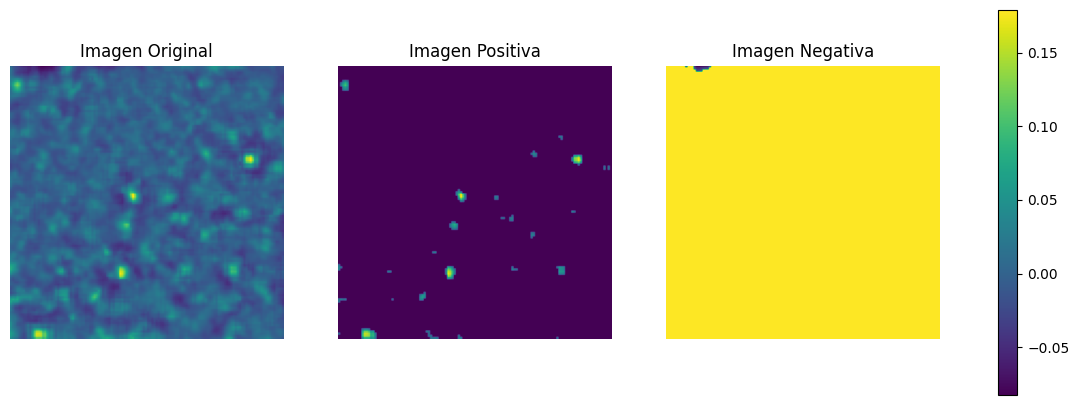

In [56]:
# Crear los subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Graficar las imágenes con el mismo rango de colores
im1 = axes[0].imshow(img, cmap='viridis')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

im2 = axes[1].imshow(img_clear_positive, cmap='viridis')
axes[1].set_title('Imagen Positiva')
axes[1].axis('off')

im3 = axes[2].imshow(img_clear_negative, cmap='viridis')
axes[2].set_title('Imagen Negativa')
axes[2].axis('off')

# Añadir una barra de color compartida
fig.colorbar(im1, ax=axes, orientation='vertical')

# Mostrar el gráfico

plt.show()

In [57]:
# ----- proceso para 1 sola imagen ------
# Generar los puntos a partir de la imagen



# --- Ajustar GMM a los puntos generados ---
from sklearn.mixture import GaussianMixture

n_gaussians_positive = 30  # Número de gaussianas para ajustar
n_gaussians_negative = 10  # Número de gaussianas para ajustar

points = generate_points_from_image(img_clear_positive)
gmm = GaussianMixture(n_components=n_gaussians_positive, covariance_type='full').fit(points)
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

negative_points = generate_points_from_image(-img_clear_negative)
gmm_negative = GaussianMixture(n_components=n_gaussians_negative, covariance_type='full').fit(negative_points)
means_negative = gmm_negative.means_
covariances_negative = gmm_negative.covariances_
weights_negative = -gmm_negative.weights_

# ---- concatenar ambos resultados

# Concatenar medios, covarianzas y pesos
combined_means = np.vstack([means, means_negative])
combined_covariances = np.vstack([covariances, covariances_negative])
combined_weights = np.hstack([weights, weights_negative])

# Reconstruir la imagen combinada
reconstructed_image = reconstruct_image_from_gmm(img.shape, combined_means, combined_covariances, combined_weights)



#--------------

# # Visualización de los puntos generados
# plt.figure(figsize=(6, 6))
# plt.scatter(points[:, 1], points[:, 0], s=1, alpha=0.5)
# plt.gca().invert_yaxis()  # Invertir eje y para que coincida con la imagen
# plt.title("Puntos generados a partir de los picos en la imagen")
# plt.show()


# # Visualización de las gaussianas ajustadas sobre los puntos
# plt.figure(figsize=(6, 6))
# plt.scatter(points[:, 1], points[:, 0], s=1, alpha=0.5, label="Puntos generados")

# # Dibujar las gaussianas ajustadas
# for mean, cov in zip(means, covariances):
#     plt.scatter(mean[1], mean[0], color='red', s=100, marker='x', label="Medias gaussianas")

# plt.gca().invert_yaxis()  # Invertir eje y para que coincida con la imagen
# plt.title("Puntos y gaussianas ajustadas")
# plt.legend()
# plt.show()

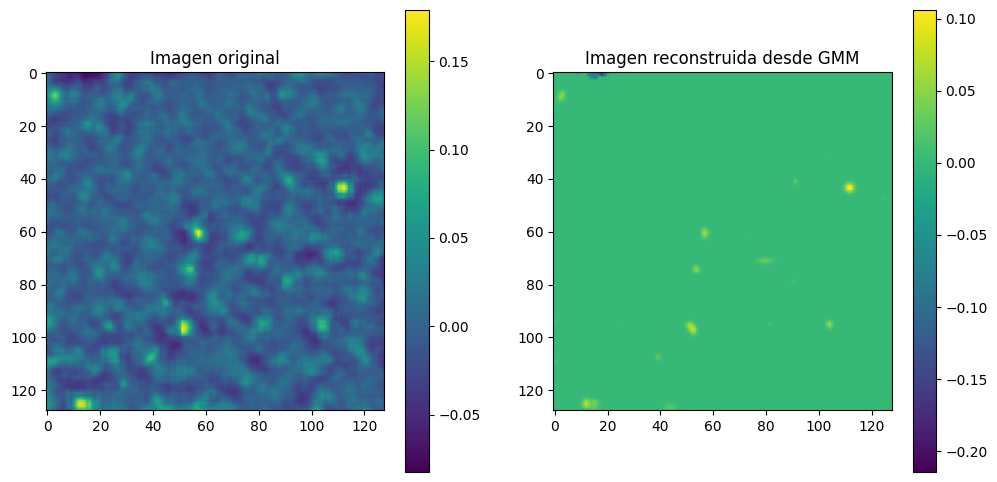

In [58]:
# --- Mostrar la imagen original y la reconstruida ---
plt.figure(figsize=(12, 6))

# Imagen original
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='viridis')
plt.title("Imagen original")
plt.colorbar()

# Imagen reconstruida
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='viridis')
plt.title("Imagen reconstruida desde GMM")
plt.colorbar()

plt.show()

# Pipeline

In [59]:
from sklearn.mixture import GaussianMixture
n_gaussians_positive = 30  # Número de gaussianas para ajustar
n_gaussians_negative = 10  # Número de gaussianas para ajustar


mean, std = calculate_image_stats(high_freq_batch) 
print(mean, std)

# -------- pipeline de trabajo con la imagen --------------------

img = high_freq_batch[0,:,:,0]


def gmm_vectors(img, mean, std, threshold=3):
    img_clear_positive, img_clear_negative = apply_threshold(img, mean, std, threshold)

    points = generate_points_from_image(img_clear_positive)
    gmm = GaussianMixture(n_components=n_gaussians_positive, covariance_type='full').fit(points)
    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_

    negative_points = generate_points_from_image(-img_clear_negative)
    gmm_negative = GaussianMixture(n_components=n_gaussians_negative, covariance_type='full').fit(negative_points)
    means_negative = gmm_negative.means_
    covariances_negative = gmm_negative.covariances_
    weights_negative = -gmm_negative.weights_

    # ---- concatenar ambos resultados

    # Concatenar medios, covarianzas y pesos
    combined_means = np.vstack([means, means_negative])
    combined_covariances = np.vstack([covariances, covariances_negative])
    combined_weights = np.hstack([weights, weights_negative])

    return combined_means, combined_covariances, combined_weights


combined_means, combined_covariances, combined_weights = gmm_vectors(img, mean, std, threshold=3)
# Reconstruir la imagen combinada
reconstructed_image = reconstruct_image_from_gmm(img.shape, combined_means, combined_covariances, combined_weights)



8.470329472543003e-21 0.019720790907782188


In [63]:
def gmm_batch_vectors(batch, n_gaussians_positive=30, n_gaussians_negative=10, threshold=2):
    batch_size = batch.shape[0]
    n_gaussianas = n_gaussians_positive + n_gaussians_negative
    combined_batch = []
    mean, std = calculate_image_stats(batch)  

    for i in range(batch_size):
        img = batch[i, :, :, 0]  # Tomamos cada imagen del batch
  
        # Aplicar umbrales y calcular GMMs
        img_clear_positive, img_clear_negative = apply_threshold(img, mean, std, threshold)

        # Verificar si hay puntos en la parte positiva
        points = generate_points_from_image(img_clear_positive)
        if len(points) == 0:
            means = np.zeros((n_gaussians_positive, 2))
            covariances = np.eye(2).reshape((1, 2, 2)).repeat(n_gaussians_positive, axis=0)
            weights = np.zeros(n_gaussians_positive)
        else:
            gmm = GaussianMixture(n_components=n_gaussians_positive, covariance_type='full').fit(points)
            means = gmm.means_
            covariances = gmm.covariances_
            weights = gmm.weights_

        # Verificar si hay puntos en la parte negativa
        negative_points = generate_points_from_image(-img_clear_negative)
        if len(negative_points) == 0:
            means_negative = np.zeros((n_gaussians_negative, 2))
            covariances_negative = np.eye(2).reshape((1, 2, 2)).repeat(n_gaussians_negative, axis=0)
            weights_negative = np.zeros(n_gaussians_negative)
        else:
            gmm_negative = GaussianMixture(n_components=n_gaussians_negative, covariance_type='full').fit(negative_points)
            means_negative = gmm_negative.means_
            covariances_negative = gmm_negative.covariances_
            weights_negative = -gmm_negative.weights_

        # Concatenar ambos resultados
        combined_means = np.vstack([means, means_negative])
        combined_covariances = np.vstack([covariances, covariances_negative])
        combined_weights = np.hstack([weights, weights_negative])

        # Extraer las desviaciones estándar (componentes diagonales de las covariancias)
        std_x = np.sqrt(np.maximum(combined_covariances[:, 0, 0], 1e-6))  # Desviación estándar en el eje x
        std_y = np.sqrt(np.maximum(combined_covariances[:, 1, 1], 1e-6))  # Desviación estándar en el eje y

        # Concatenar todos los valores relevantes en un vector (mean_x, mean_y, std_x, std_y, weight)
        combined_vectors = np.column_stack([combined_means[:, 0],  # mean_x
                                            combined_means[:, 1],  # mean_y
                                            std_x,                 # std_x
                                            std_y,                 # std_y
                                            combined_weights])     # weight

        combined_batch.append(combined_vectors)

    # Convertir la lista en un numpy array con shape (batch_size, n_gaussianas, 5)
    combined_batch = np.array(combined_batch)
    
    return combined_batch


In [64]:
# Suponiendo que high_freq_batch tiene la forma (batch_size, height, width, channels)
batch_size = high_freq_batch.shape[0]

# Aplicar GMM a todo el batch
combined_batch = gmm_batch_vectors(high_freq_batch, n_gaussians_positive=30, n_gaussians_negative=10, threshold=3)

print(combined_batch.shape)  # Debería imprimir (batch_size, 40, 5)

c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10).

(64, 40, 5)
